<div align=center>

# Principles of Simulation: Assignment 1

By Hamed Araab & Shahriar Khalvati

</div>


### Prerequisites

In this section, we import necessary libraries and modules required for the
execution of subsequent code cells:


In [1]:
import random
import pandas as pd
import seaborn as sns

from framework import *

### Server


In [2]:
class Server:
    """
    A class representing a server in a simulation.

    Attributes:
    - status (Literal["available", "busy"]): The current status of the server.
    - totalBusyTime (float): The total time the server has been busy.
    """

    def __init__(self) -> None:
        """
        Initialize the Server.
        """

        self.status: Literal["available", "busy"] = "available"
        self.totalBusyTime: float = 0

### Customer


In [3]:
class Customer:
    """
    A class representing a customer in a simulation.

    Attributes:
    - serviceTime (float): The time taken to serve the customer.
    - departure (float): The time when the customer departs.
    - arrival (float): The time when the customer arrives.
    """

    def __init__(self) -> None:
        """
        Initialize the Customer.
        """

        self.serviceTime: float
        self.departure: float
        self.arrival: float

    @property
    def totalTime(self) -> float:
        """
        Calculate the total time spent by the customer in the system.

        Returns:
        - float: The total time spent by the customer in the system.
        """

        return self.departure - self.arrival

    @property
    def waitingTime(self) -> float:
        """
        Calculate the waiting time experienced by the customer.

        Returns:
        - float: The waiting time experienced by the customer.
        """

        return self.totalTime - self.serviceTime

### Server Selection Strategy

The `ServerSelectionStrategy` class defines different strategies for selecting a
server from a pool of servers. Two strategies are implemented as static methods:

- `firstAvailable`: This method selects the first available server from the
  provided dictionary of servers.
- `randomAvailable`: This method randomly selects an available server from the provided
  dictionary of servers.


In [4]:
class ServerSelectionStrategy:
    """
    A class providing different strategies for selecting servers in a simulation.
    """

    @staticmethod
    def firstAvailable(servers: Dict[int, Server]) -> int:
        """
        Select the first available server.

        Args:
        - servers (Dict[int, Server]): A dictionary of servers indexed by their IDs.

        Returns:
        - int: The ID of the first available server, or -1 if no server is available.
        """

        serverId: int = -1
        serversList = list(servers.items())

        for id, server in serversList:
            if server.status == "available":
                serverId = id

                break

        return serverId

    @staticmethod
    def randomAvailable(servers: Dict[int, Server]) -> int:
        """
        Select an available server randomly.

        Args:
        - servers (Dict[int, Server]): A dictionary of servers indexed by their IDs.

        Returns:
        - int: The ID of a randomly selected available server, or -1 if no server is available.
        """

        serverId: int = -1
        serversList = list(servers.items())

        random.shuffle(serversList)

        for id, server in serversList:
            if server.status == "available":
                serverId = id

                break

        return serverId

### General Form of the Problem: Single Queue Multi-Server

The `SingleQueueMultiServerController` class represents a controller for
simulating a single queue multi-server system. It inherits from `SimController`
class.


In [5]:
class SingleQueueMultiServerController(SimController):
    """
    A class representing a controller for a single queue multiple server simulation.
    """

    def __init__(
        self,
        initialEvent: SimEvent,
        stopTime: float,
        numberOfServers: int,
        serverSelectionStrategy: Callable[[Dict[int, Server]], int],
    ) -> None:
        """
        Initialize the SingleQueueMultiServerController.

        Args:
        - initialEvent (SimEvent): The initial event to start the simulation.
        - stopTime (float): The time at which the simulation should stop.
        - numberOfServers (int): The number of servers in the simulation.
        - serverSelectionStrategy (Callable[[Dict[int, Server]], int]): The strategy for selecting servers.

        Raises:
        - AssertionError: If numberOfServers is non-positive.
        """

        assert numberOfServers > 0, "Non-positive number of servers"

        super().__init__(initialEvent, stopTime)

        self.historicalCustomers: List[Customer] = []
        self.customersQueue: List[Customer] = []

        self.servers: Dict[int, Server] = {
            i: Server() for i in range(1, numberOfServers + 1)
        }

        self.serverSelectionStrategy = serverSelectionStrategy

    def simulate(self) -> Dict[str, float]:
        """
        Run the simulation and collect performance metrics.

        Returns:
        - Dict[str, float]: A dictionary containing performance metrics.

        Metrics:
        - ABTP: Average busy time percentage.
        - AWTP: Average waiting time percentage.
        """

        super().simulate()

        abtp = sum(
            server.totalBusyTime / self.clock for server in self.servers.values()
        ) / len(self.servers)

        awtp = sum(
            customer.waitingTime / customer.totalTime
            for customer in self.historicalCustomers
        ) / len(self.historicalCustomers)

        return {"ABTP": abtp, "AWTP": awtp}

### Special Case: Able & Baker

The `AbleBakerController` class extends the `SingleQueueMultiServerController`
class to simulate a special case known as the Able & Baker system.


In [6]:
class AbleBakerController(SingleQueueMultiServerController):
    """
    A class representing a controller for an Able-Baker simulation scenario.
    """

    def __init__(
        self,
        initialEvent: SimEvent,
        stopTime: float,
        serverSelectionStrategy: Callable[[Dict[int, Server]], int],
    ) -> None:
        """
        Initialize the AbleBakerController.

        Args:
        - initialEvent (SimEvent): The initial event to start the simulation.
        - stopTime (float): The time at which the simulation should stop.
        - serverSelectionStrategy (Callable[[Dict[int, Server]], int]): The strategy for selecting servers.
        """

        super().__init__(
            initialEvent,
            stopTime,
            numberOfServers=2,
            serverSelectionStrategy=serverSelectionStrategy,
        )

    def simulate(self) -> Dict[str, float]:
        """
        Run the simulation and collect performance metrics.

        Returns:
        - Dict[str, float]: A dictionary containing performance metrics.

        Metrics:
        - TC: Total customers.
        - AWT: Average waiting time.
        - QCP: Queued customers percentage.
        - BTP_i: Busy time percentage of the ith server.
        """

        super().simulate()

        positiveWaitingTimes = list(
            filter(
                lambda waitingTime: waitingTime > 0,
                map(lambda customer: customer.waitingTime, self.historicalCustomers),
            )
        )

        return {
            "TC": len(self.historicalCustomers),
            "AWT": sum(positiveWaitingTimes) / len(self.historicalCustomers),
            "QCP": len(positiveWaitingTimes) / len(self.historicalCustomers),
        } | {
            f"BTP_{id}": server.totalBusyTime / self.clock
            for id, server in self.servers.items()
        }

### Departure Event

This code defines the `DepartureEvent` class, which represents an event
occurring when a customer departs from a server in the simulation.


In [7]:
DEPARTURE_EVENT_INTERVAL: Callable[[], float] = None


class DepartureEvent(SimEvent[SingleQueueMultiServerController]):
    """
    A class representing a departure event in a single queue multiple server simulation.
    """

    def __init__(self, customer: Customer, serverId: int) -> None:
        """
        Initialize the DepartureEvent.

        Args:
        - customer (Customer): The customer departing.
        - serverId (int): The ID of the server from which the customer departs.

        Raises:
        - AssertionError: If serverId is less than 1.
        """

        super().__init__(DEPARTURE_EVENT_INTERVAL())

        assert serverId >= 1

        self.customer = customer
        self.serverId = serverId

    def trigger(self) -> None:
        """
        Trigger the departure event.
        """

        self.customer.serviceTime = self.interval
        self.customer.departure = self.dueTime

        self.controller.historicalCustomers.append(self.customer)

        self.controller.servers[self.serverId].totalBusyTime += self.interval

        if self.controller.customersQueue:
            customer = self.controller.customersQueue.pop(0)

            self.controller.dispatchEvent(DepartureEvent(customer, self.serverId))
        else:
            self.controller.servers[self.serverId].status = "available"

### Arrival Event

This code defines the `ArrivalEvent` class, representing an event occurring when
a new customer arrives at the system.


In [8]:
ARRIVAL_EVENT_INTERVAL: Callable[[], float] = None


class ArrivalEvent(SimEvent[SingleQueueMultiServerController]):
    """
    A class representing an arrival event in a single queue multiple server simulation.
    """

    def __init__(self, initial: bool = False) -> None:
        """
        Initialize the ArrivalEvent.

        Args:
        - initial (bool, optional): Whether this is the initial arrival event. Defaults to False.
        """

        super().__init__(0 if initial else ARRIVAL_EVENT_INTERVAL())

        self.customer = Customer()

    def trigger(self) -> None:
        """
        Trigger the arrival event.
        """

        self.customer.arrival = self.dueTime

        self.controller.dispatchEvent(ArrivalEvent())

        serverId = self.controller.serverSelectionStrategy(self.controller.servers)

        if serverId == -1:
            self.controller.customersQueue.append(self.customer)
        else:
            self.controller.servers[serverId].status = "busy"
            self.controller.dispatchEvent(DepartureEvent(self.customer, serverId))

### Problem 1

In this section, we have the Able & Baker problem:

- Arrival events follow a uniform distribution with a minimum interval of 3
  minutes and a maximum interval of 6 minutes.
- Departure events follow a uniform distribution with a minimum interval of 9
  minutes and a maximum interval of 12 minutes.
- The simulation runs for a total duration of 9 hours (9 \* 60 minutes).

After running the simulation for 1000 iterations, the mean of simulation results
across all iterations is calculated and displayed as a `DataFrame`. This
provides insights into various performance metrics of the system.


#### Selecting the First Available Server


In [9]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(9, 12)

allResults: List[Dict[str, float]] = []

for i in range(1000):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stopTime=9 * 60,
        serverSelectionStrategy=ServerSelectionStrategy.firstAvailable,
    ).simulate()

    allResults.append(results)

pd.DataFrame(allResults).mean(axis=0)

TC       101.393000
AWT       37.469566
QCP        0.977428
BTP_1      0.992983
BTP_2      0.984609
dtype: float64

#### Selecting Servers Randomly


In [10]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(3, 6)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(9, 12)

allResults: List[Dict[str, float]] = []

for i in range(1000):
    results = AbleBakerController(
        initialEvent=ArrivalEvent(initial=True),
        stopTime=9 * 60,
        serverSelectionStrategy=ServerSelectionStrategy.randomAvailable,
    ).simulate()

    allResults.append(results)

pd.DataFrame(allResults).mean(axis=0)

TC       101.419000
AWT       37.424041
QCP        0.977960
BTP_1      0.988373
BTP_2      0.989064
dtype: float64

### Problem 2

In this problem, a simulation is conducted to analyze the performance of a
single queue multi-server system with varying numbers of servers.

In this simulation:

- Arrival events follow a uniform distribution with a minimum interval of 0
  minutes and a maximum interval of 4 minutes.
- Departure events follow a uniform distribution with a minimum interval of 6
  minutes and a maximum interval of 10 minutes.
- The simulation runs for a total duration of 8 hours (8 \* 60 minutes) for each
  number of servers ranging from 1 to 10.
- The server selection strategy used is random, where servers are selected
  randomly for service.

After running the simulation for each number of servers, the mean of simulation
results across all iterations is calculated and stored in a `DataFrame`.


#### Solution


In [11]:
ARRIVAL_EVENT_INTERVAL = lambda: DistributionFunction.uniform(0, 4)
DEPARTURE_EVENT_INTERVAL = lambda: DistributionFunction.uniform(6, 10)

allResults: List[Tuple[int, float, float]] = []

for numberOfServers in range(1, 11):
    iterResults: List[Dict[str, float]] = []

    for i in range(1000):
        results = SingleQueueMultiServerController(
            initialEvent=ArrivalEvent(initial=True),
            stopTime=8 * 60,
            numberOfServers=numberOfServers,
            serverSelectionStrategy=ServerSelectionStrategy.randomAvailable,
        ).simulate()

        iterResults.append(results)

    allResults.append(
        (
            numberOfServers,
            *pd.DataFrame(iterResults).mean(axis=0).to_list(),
        )
    )

resultsDf = pd.DataFrame(
    allResults,
    columns=["numberOfServers", "ABTP", "AWTP"],
).set_index("numberOfServers")

resultsDf

,ABTP,AWTP
numberOfServers,,
1,0.993962,0.904690
2,0.991457,0.874114
3,0.988617,0.799805
4,0.960052,0.402293
5,0.787723,0.056432
6,0.658320,0.012516
7,0.563766,0.002888
8,0.493659,0.000599
9,0.438806,0.000143


Here, we calculate the weighted average of `ABTP` and `1 - AWTP` to find the
optimal number of servers for this system. Higher values of `alpha` prioritize maximizing
`ABTP` while the lower ones prioritize minimizing `AWTP`.


In [12]:
def getScores(alpha: float) -> pd.Series:
    """
    Calculate the performance scores of the system.

    Args:
    - alpha (float): Priority of maximizing ABTP against minimizing AWTP.

    Returns:
    - pd.Series: The performance score of the system for each number of servers.
    """

    assert alpha > 0 and alpha < 1, "alpha must be in range (0, 1)"

    scores = alpha * resultsDf["ABTP"] + (1 - alpha) * (1 - resultsDf["AWTP"])

    return scores


optimalNumbersOfServers: List[Tuple[float, int]] = []

for i in range(1, 1000):
    alpha = i / 1000
    scores = getScores(alpha)

    if i % 200 == 0:
        resultsDf[f"Score (alpha={alpha})"] = scores

    optimalNumbersOfServers.append((alpha, scores.idxmax()))

optimalNumbersOfServersDf = pd.DataFrame(
    optimalNumbersOfServers,
    columns=["alpha", "optimalNumberOfServers"],
).set_index("alpha")

resultsDf

,ABTP,AWTP,Score (alpha=0.2),Score (alpha=0.4),Score (alpha=0.6),Score (alpha=0.8)
numberOfServers,,,,,,
1,0.993962,0.904690,0.275040,0.454771,0.634501,0.814231
2,0.991457,0.874114,0.299001,0.472115,0.645229,0.818343
3,0.988617,0.799805,0.357879,0.515563,0.673248,0.830932
4,0.960052,0.402293,0.670176,0.742645,0.815114,0.887583
5,0.787723,0.056432,0.912399,0.881230,0.850061,0.818892
6,0.658320,0.012516,0.921651,0.855818,0.789986,0.724153
7,0.563766,0.002888,0.910443,0.823774,0.737104,0.650435
8,0.493659,0.000599,0.898253,0.797104,0.695956,0.594808
9,0.438806,0.000143,0.887647,0.775437,0.663226,0.551016


In [13]:
optimalNumbersOfServersDf

,optimalNumberOfServers
alpha,
0.001,10
0.002,10
0.003,9
0.004,9
0.005,9
...,...
0.995,1
0.996,1
0.997,1


##### Results

To visualize the results of Problem 2, we can use `seaborn` to create two line
plot based on the last two data frames containing the simulation results.


<Axes: xlabel='numberOfServers'>

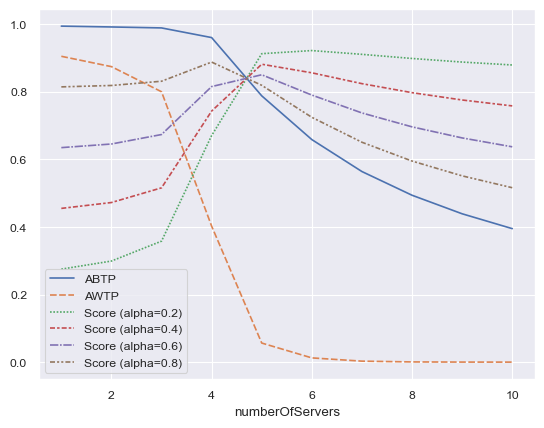

In [14]:
sns.set_theme("paper")
sns.lineplot(resultsDf)

<Axes: xlabel='alpha'>

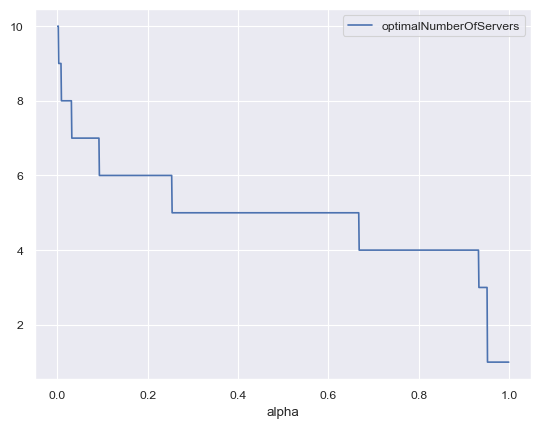

In [15]:
sns.set_theme("paper")
sns.lineplot(optimalNumbersOfServersDf)

Based on this chart, we recommend choosing a value of `0.5` for `alpha`. Thus,
the optimal number of servers will be `5`. However, another value for `alpha`
can be chosen based on the priorities of the stakeholders of this system.
